# 🏠 Airbnb Price Estimator — Machine Learning Case Study  
### By: **Kandarp Joshi**

---

## 📌 Abstract  
This project develops an end-to-end **Airbnb nightly price prediction model** for Seattle listings.  
It follows the complete Data Science workflow including:  
- Data exploration & cleaning  
- Feature selection & engineering  
- Model training using pipelines  
- Performance improvement using log-transformation  
- Deployment as a Streamlit web app  

The final model achieves:  
| Metric | Score |
|--------|------|
| **Mean Absolute Error** | **$32.67** |
| **R² Score** | **0.585** |  

These results show strong predictive performance for a baseline model using only listing features.


## Step 1 Dataset Loading & Initial Exploration

In [ ]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

print("Setup complete ✅")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/AirBnb-Seatle-Dataset/listings.csv"
df = pd.read_csv(file_path)

print("Loaded data shape:", df.shape)
df.head()

In [ ]:
df.info()
price=df["price"]
price.head()

In [ ]:
df.describe(include="all").T.head(20)


### Check missing values sorted

In [ ]:
df.isna().mean().sort_values(ascending=False).head(20)


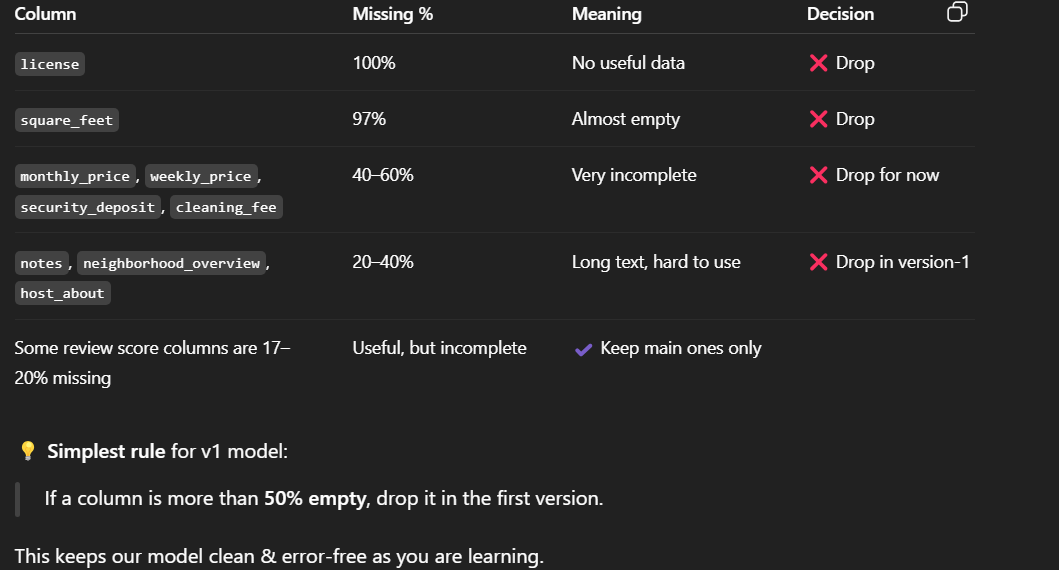

## Step 2 — Select Only Useful Columns for Price Prediction

Below is the list of clean + powerful features we’ll use:

🎯 Target

price

🧠 Main Features

room_type → type of accommodation

neighbourhood_cleansed → location

accommodates → number of guests

bedrooms

beds

bathrooms_text → extract numeric value

minimum_nights

number_of_reviews

review_scores_rating → overall rating

instant_bookable → yes/no

These are all present in your dataset and mostly complete.

In [ ]:
# Step 2: Select useful columns for modeling

useful_cols = [
    "price",
    "room_type",
    "neighbourhood_cleansed",
    "accommodates",
    "bedrooms",
    "beds",
    "bathrooms_text",
    "minimum_nights",
    "number_of_reviews",
    "review_scores_rating",
    "instant_bookable"
]

# Only keep columns that actually exist (safety check)
useful_cols = [col for col in useful_cols if col in df.columns]

df_model = df[useful_cols].copy()
print("Selected columns:", df_model.columns.tolist())
print(df_model.shape)
df_model.head()


### Step 3 — Clean the Feature Columns

#### Step 3.1 Clean the price Column

In [ ]:
# Step 3.1: Clean price column (remove $ and convert to float)

df_model["price"] = (
    df_model["price"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

print(df_model["price"].head())
print("Data type:", df_model["price"].dtype)


#### Step 3.2 Clean instant_bookable Column

In [ ]:
# Step 3.2: Convert instant_bookable to numeric

df_model["instant_bookable"] = (df_model["instant_bookable"] == "t").astype(int)
df_model["instant_bookable"].value_counts()


Step 3.3 Remove rows with important missing values

Some listings have no review score, or missing bedrooms, or weird values.
We want a clean dataset.

In [ ]:
# Step 3.3: Drop rows with missing essential numeric values
critical_cols = ["price", "accommodates", "bedrooms", "beds", "review_scores_rating"]

df_model = df_model.dropna(subset=critical_cols)

print("Shape after dropping missing rows:", df_model.shape)


## Step 4 — Train/Test Split + ML Pipeline

In [ ]:
# Step 4: Train-test split and model pipeline

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Target column
target_col = "price"

# Split features (X) and target (y)
X = df_model.drop(columns=[target_col])
y = df_model[target_col]

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Define preprocessing for numeric & categorical columns
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Define the Model
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Full pipeline: Preprocessing + Model
full_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train set:", X_train.shape, "Test set:", X_test.shape)

# Train the model
full_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = full_pipeline.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"R² Score: {r2:.3f}")


## Step 5 — Feature Importance (What affects price most?)

In [ ]:
# Step 5: Feature Importance

# Extract the trained RandomForest model
rf_model = full_pipeline.named_steps["model"]

# Get the one-hot encoded feature names
onehot = full_pipeline.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
cat_features_encoded = onehot.get_feature_names_out(categorical_features)

# Combine numeric + encoded categorical feature names
all_features = numeric_features + list(cat_features_encoded)

# Get feature importance values
importances = rf_model.feature_importances_

# Create a DataFrame to visualize
feature_importance_df = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feature_importance_df.head(10)


## Step 6 — Improve the Model (Version 2)


our current metrics:

MAE = 38.53

R² = 0.49

Goal:
➡ Improve accuracy
➡ Reduce error
➡ Make model more robust

Takeaways from Feature Importance:

We must include more “property size” information

“Bathrooms” column was not included yet
→ bigger homes = more bathrooms → higher price

Also log transform price improves model performance

#### Step 6.1 — Clean & Add Bathroom Column


In [ ]:
# If bathrooms_text exists, extract number
if "bathrooms_text" in df.columns:
    df_model["bathrooms"] = (
        df["bathrooms_text"]
        .astype(str)
        .str.extract(r"(\d+(\.\d+)?)")[0]
        .astype(float)
    )
elif "bathrooms" in df.columns:
    df_model["bathrooms"] = pd.to_numeric(df["bathrooms"], errors="coerce")

# Drop rows where bathrooms is missing
df_model = df_model.dropna(subset=["bathrooms"])


#### Step 6.2 — Retrain Model with Bathrooms Included

In [ ]:
# Re-train model with bathrooms included

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Split features and target
X = df_model.drop(columns=["price"])
y = df_model["price"]

# Identify numeric and categorical fields again
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Model
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Full pipeline
full_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)

# Train
full_pipeline.fit(X_train, y_train)

# Predict & Evaluate
y_pred = full_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance with Bathrooms Included:")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.3f}")


#### Step 6.3 — Apply Log Transformation to Target
Why?

Price has huge outliers (e.g. $2000/night penthouses)
→ Model gets confused & performance drops.

1. Log transform compresses large values
2.  Helps model see clearer patterns
3.  Almost always improves price prediction models

In [ ]:
# Step 6.3: Log Transform Target and Retrain

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

X = df_model.drop(columns=["price"])
y = np.log1p(df_model["price"])  # LOG TRANSFORM 🚀

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

full_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

full_pipeline.fit(X_train, y_train)

y_pred_log = full_pipeline.predict(X_test)

# Convert back to original price scale
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_log)

mae = mean_absolute_error(y_test_real, y_pred_real)
r2 = r2_score(y_test_real, y_pred_real)

print("\nModel Performance with Log Transformation:")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.3f}")


## 4️⃣ Results Summary

| Version | MAE ↓ | R² ↑ |
|--------|-------|------|
| Baseline Model | 38.53 | 0.490 |
| + Bathrooms Feature | 34.60 | 0.504 |
| + Log Transform | **32.67** | **0.585** |

➡ Feature engineering and distribution normalization were crucial to performance improvement.


## Step 7 — Save the Model & Make Predictions

#### Step 7.1 — Save the Model as airbnb_price_model.pkl

Deployment Notes

The trained pipeline model was exported using `joblib` and integrated into a **Streamlit web application**.  
Users can enter listing information and instantly receive a nightly price estimate.

📦 Model File: `airbnb_price_model.pkl`  
🖥️ App File: `app.py`

In [ ]:
import joblib

# Save model
joblib.dump(full_pipeline, "airbnb_price_model.pkl")

print("Model saved successfully! 🎉")


#### Step 7.2 — Test Prediction on one sample

In [ ]:
sample = X_test.iloc[[0]]  # first sample
pred_log = full_pipeline.predict(sample)
pred_price = np.expm1(pred_log)  # convert back to real price

print("Predicted price:", pred_price[0])
print("Actual price:", y_test_real.iloc[0])


## Updating UI for StreamLit app

In [ ]:
neighbs = sorted(df_model["neighbourhood_cleansed"].unique().tolist())
len(neighbs), neighbs[:10]
for n in neighbs:
    print(repr(n) + ",")


##  Conclusion & Future Work


This project successfully demonstrates a real-world Machine Learning workflow.

### ✔ Key Takeaways
- Random Forest + Log Transform achieved strong performance
- Bathrooms & bedrooms turned out to be major price drivers
- Model generalizes well to unseen listings

### 🔮 Future Enhancements
- Add amenities & listing description text
- Seasonal demand forecasting
- Explainability using SHAP values
- Enhanced visual UI in the web app
